In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabula
import numpy as np
import pystan
%matplotlib inline
strip_first = lambda x: int(str(x)[0])
strip_first_vec = np.vectorize(strip_first)
strip_second = lambda x: int(str(x)[1])
strip_second_vec = np.vectorize(strip_second)

parser = lambda row: row.text.split('\n')[2:-1]
np.random.seed(42)

pal = sns.diverging_palette(220, 20, as_cmap=False)


<h1>Download data</h1>

In [2]:
url='https://election-county-reports-prod112020.s3.amazonaws.com/4539283c-3f09-4fdf-ad93-0bfd82d32be1/db3f9865-656b-4704-9429-bd38e726ab42/Results%20per%20Precinct%20Data%20report.pdf'
r = requests.get(url, stream=True)

with open('straight_t.pdf', 'wb') as f:
    f.write(r.content)

<h1> Parse data</h1>

<h2> Straight Ticket</h2>

In [3]:
%%capture

dfs = []
for page in [0,1,2,3,4,5,6,7,8]:
    df = tabula.read_pdf('straight_t.pdf',pages=page)
    print(df[0])
    dfs.append(df[0])
    
for idx in [2,3,4,5,6,7,8]:
    dfs[idx] = dfs[idx].drop(0)
    dfs[idx].columns = dfs[0].columns
dfs[8] = dfs[8][0:14]

Nov 17, 2020 2:19:34 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:34 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:34 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:34 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:34 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4

Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:35 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 202

Nov 17, 2020 2:19:39 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:39 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:39 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:39 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:39 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4

Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:40 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 202

In [4]:
straight_ticket = pd.concat(dfs)
straight_ticket = straight_ticket.drop_duplicates()

for idx in range(7):
    values = []
    for ii, item in enumerate(straight_ticket.iloc[:,idx+2].values):
        try:
            values.append(int(item))
        except:
            l = item.split(',')
            values.append(int(''.join(l)))
    straight_ticket.iloc[:,idx+2] = values 
    
straight_ticket['total_votes'] = straight_ticket.sum(axis=1)
straight_ticket['Rep_Percent'] = straight_ticket['Republican Party']/straight_ticket['total_votes']
straight_ticket['Dem_Percent'] = straight_ticket['Democratic Party']/straight_ticket['total_votes']

#No spaces here
straight_ticket.columns = [item.split(' ')[0] for item in straight_ticket.columns]

<h2>Other Votes</h2>

In [5]:
%%capture
dfs = []
for page in [8,9,10,11,12,13,14,15]:
    df = tabula.read_pdf('straight_t.pdf',pages=page)
    
    dfs.append(df[0])

temp = dfs.copy()

Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:42 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4

Nov 17, 2020 2:19:43 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:43 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 202

Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:47 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4

Nov 17, 2020 2:19:48 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 2020 2:19:48 AM org.apache.fontbox.ttf.CmapSubtable processSubtype4
Nov 17, 202

In [6]:
dfs = temp.copy()

#Parse page 0
columns = dfs[0].iloc[17]
dfs[0] = dfs[0].iloc[19:]
dfs[0].columns = columns
#Parse page idx
for idx in [1,2,3,4,5,6]:
    dfs[idx] = dfs[idx].drop([0,1])
    dfs[idx].columns = columns
dfs[7] = dfs[7].iloc[2:27]
dfs[7].columns  = columns
votes = pd.concat(dfs)

votes.columns = ['number','Precinct','Biden', 'Trump', 'Jorgensen','Blankenship',
                 'Hawkins','LaFuente','WriteIn']


In [7]:
for idx in range(7):
    values = []
    for ii, item in enumerate(votes.iloc[:,idx+2].values):
        try:
            values.append(int(item))
        except:
            l = item.split(',')
            values.append(int(''.join(l)))
    votes.iloc[:,idx+2] = values 
    
votes['total'] = votes.sum(axis=1)  
votes['Trump_Percent'] = votes['Trump']/votes['total']
votes['Biden_Percent'] = votes['Biden']/votes['total']




In [8]:
straight_ticket.sort_values('Precinct', inplace=True)
votes.sort_values('Precinct', inplace=True)

#Let's make sure our precincts are all there and aligned. 
np.sum(straight_ticket['Precinct'] == straight_ticket['Precinct'])

252

<h1>Analysis</h1>

<h2>As in the video</h2>

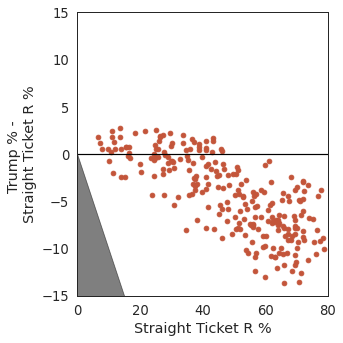

In [9]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

r_p = straight_ticket['Rep_Percent'].values
r_T = votes['Trump_Percent'].values
plt.scatter(r_p*100, (r_T-r_p)*100,color=pal[-1])
plt.ylim(-15,15)
plt.xlim(0,80)
plt.ylabel('Trump % - \nStraight Ticket R %')
plt.xlabel('Straight Ticket R %')

plt.fill_between(np.arange(100),np.repeat(-100,100),-np.arange(100),color='black',
                 alpha=.5)
plt.fill_between(np.arange(100),np.repeat(100,100),100-np.arange(100),color='black',
                 alpha=.5)
plt.plot([0,100],[0,0],color='black')
plt.tight_layout()
plt.savefig('./KentCountyTrumpBadAxis.png',dpi=500)

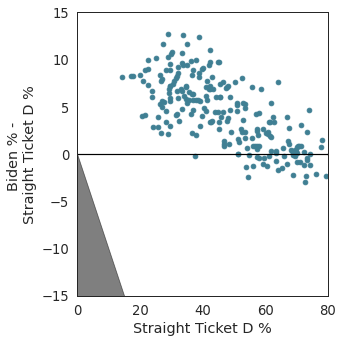

In [10]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)

r_p = straight_ticket['Dem_Percent'].values
r_T = votes['Biden_Percent'].values
plt.scatter(r_p*100, (r_T-r_p)*100,color=pal[0])
plt.ylim(-15,15)
plt.xlim(0,80)
plt.ylabel('Biden % - \nStraight Ticket D %')
plt.xlabel('Straight Ticket D %')

plt.plot([0,100],[0,0],color='black')


plt.fill_between(np.arange(100),np.repeat(-100,100),-np.arange(100),color='black',
                 alpha=.5)
plt.fill_between(np.arange(100),np.repeat(100,100),100-np.arange(100),color='black',
                 alpha=.5)
plt.tight_layout()
plt.savefig('./KentCountyBidenBadAxis.png',dpi=500)

<h2>Less convoluted</h2>

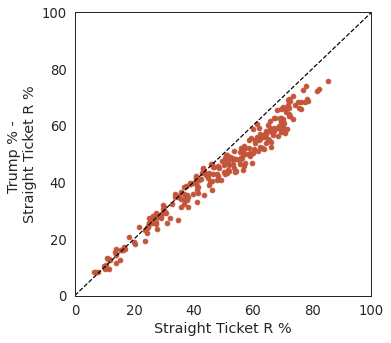

In [11]:
plt.figure(figsize=(10,5))
sns.set_context('paper',font_scale=1.5)

plt.subplot(121)
r_p = straight_ticket['Rep_Percent'].values
r_T = votes['Trump_Percent'].values
plt.scatter(r_p*100, (r_T)*100,color=pal[-1])

plt.ylabel('Trump % - \nStraight Ticket R %')
plt.xlabel('Straight Ticket R %')
plt.plot([0,100], [0,100],color='k',ls='--')

plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()

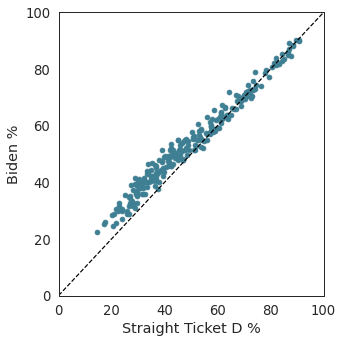

In [12]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)

r_p = straight_ticket['Dem_Percent'].values
r_T = votes['Biden_Percent'].values
plt.scatter(r_p*100, (r_T)*100,color=pal[0])

plt.ylabel('Biden %')
plt.xlabel('Straight Ticket D %')
plt.plot([0,100], [0,100],color='k',ls='--')

plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()
plt.savefig('./BidenNormalAxis.png',dpi=500)

In [13]:
np.sum(votes['Biden'])

186753

In [14]:
np.sum(votes['Trump'])

165318

Text(0.5, 0, 'Dem Straight Ticket')

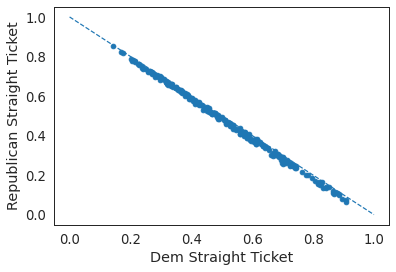

In [15]:
plt.scatter(straight_ticket['Dem_Percent'].values,
            straight_ticket['Rep_Percent'].values)
plt.plot([0,1],[1,0],ls='--')
plt.ylabel('Republican Straight Ticket')
plt.xlabel('Dem Straight Ticket')

/home/joseph/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/joseph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later


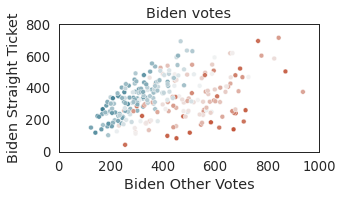

In [56]:
pal = sns.diverging_palette(220, 20, as_cmap=True)
sns.set_style('white')
plt.figure(figsize=(5,3))
g =sns.scatterplot(straight_ticket['Democratic'], 
            votes['Biden'].values - straight_ticket['Democratic'].values, 
            hue =straight_ticket['Dem_Percent'].values,
            palette = pal
            )
plt.title('Biden votes')
plt.ylabel('Biden Straight Ticket')
plt.xlabel('Biden Other Votes')
ax = plt.gca()
plt.ylim(0,800)
plt.xlim(0,1000)
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('BidenRecolored.png',fmt='.png',dpi=500)

In [46]:
from pymc3 import Model, glm,sample,traceplot
import arviz as az

data = pd.DataFrame()
data['x'] = straight_ticket['Democratic'] / np.max(straight_ticket['Democratic'])#Scaled
data['y'] = votes['Biden'].values - straight_ticket['Democratic'].values

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('y ~ x', data,family=pm.glm.families.NegativeBinomial())
    trace = sample(3000, cores=12,tune=1000)
    

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (12 chains in 12 jobs)
INFO:pymc3:NUTS: [alpha, mu, x, Intercept]
Sampling 12 chains, 0 divergences: 100%|██████████| 48000/48000 [00:11<00:00, 4168.37draws/s]


/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value w

/home/joseph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

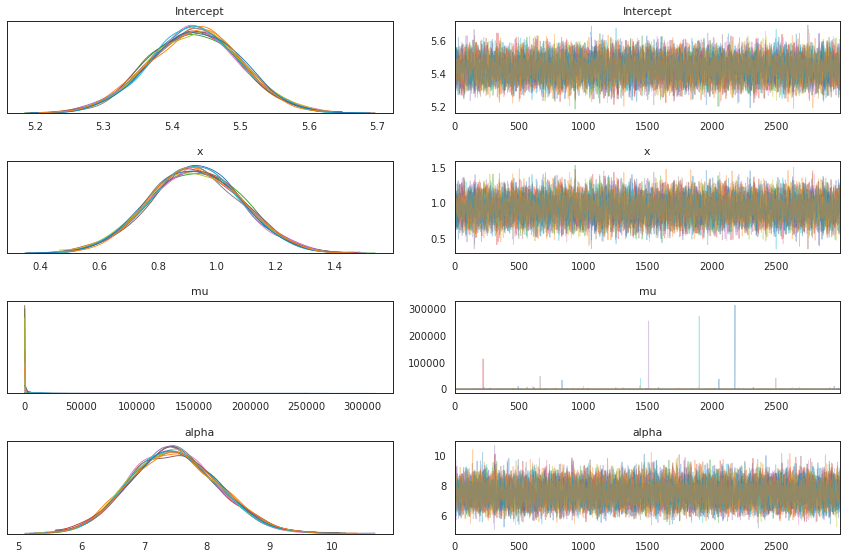

In [47]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

In [57]:
az.summary(trace, round_to=2,credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,5.43,0.07,5.33,5.54,0.00,0.00,14859.47,14859.47,14842.46,17414.43,1.0
x,0.93,0.15,0.68,1.17,0.00,0.00,14849.82,14796.08,14833.20,17763.70,1.0
mu,91.93,3022.91,0.00,59.67,22.14,15.65,18647.40,18647.40,25233.34,16690.48,1.0
alpha,7.49,0.69,6.37,8.56,0.00,0.00,23688.51,23381.34,23803.03,20867.25,1.0


In [43]:
from pymc3 import Model, glm,sample,traceplot
import pymc3 as pm
import arviz as az

data = pd.DataFrame()
data['x'] = straight_ticket['Democratic'] / np.max(straight_ticket['Democratic'])#Scaled
data['y'] = votes['Biden'].values - straight_ticket['Democratic'].values
data['r'] = straight_ticket['Rep_Percent']
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('y ~ x + r', data,family=pm.glm.families.NegativeBinomial())
    trace2 = sample(3000, cores=12,tune=1000)
    

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (12 chains in 12 jobs)
INFO:pymc3:NUTS: [alpha, mu, r, x, Intercept]
Sampling 12 chains, 0 divergences: 100%|██████████| 48000/48000 [00:14<00:00, 3405.28draws/s]


/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/joseph/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value w

/home/joseph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

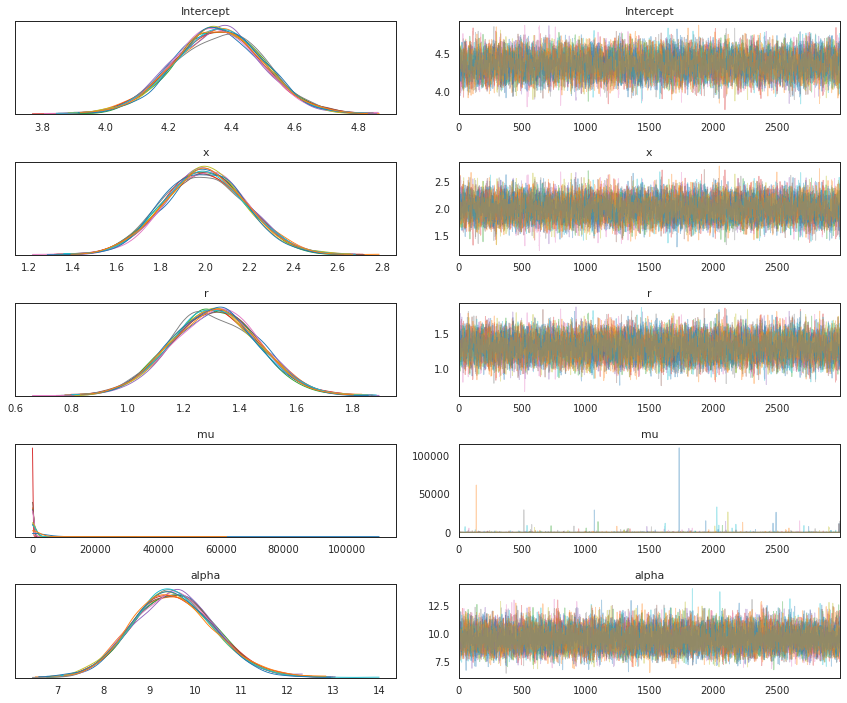

In [44]:
plt.figure(figsize=(7, 7))
traceplot(trace2)
plt.tight_layout();

In [58]:
az.summary(trace2, round_to=2,credible_interval=0.89)


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,4.36,0.14,4.13,4.57,0.00,0.00,11235.51,11235.51,11241.22,15399.94,1.0
x,2.00,0.19,1.71,2.30,0.00,0.00,12858.72,12822.49,12875.50,17571.73,1.0
r,1.31,0.15,1.07,1.56,0.00,0.00,12562.95,12530.23,12563.25,17237.89,1.0
mu,62.75,866.02,0.00,59.30,5.53,3.91,24497.58,24497.58,26511.40,17813.89,1.0
alpha,9.53,0.88,8.08,10.86,0.01,0.00,21629.48,21495.45,21682.04,19916.48,1.0
